<a href="https://colab.research.google.com/github/khadkechetan/information_extraction/blob/main/Docvqa/Docvqa_imperia_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Owner: **Chetan Khadke** (khadkechetan@gmail.com)  ✌



In [1]:
!pip install git+https://github.com/huggingface/transformers.git@2ef774211733f0acf8d3415f9284c49ef219e991
!pip install torch
!pip install datasets
!pip install pillow
!pip install sentencepiece  #  naver-clova-ix/donut-base-finetuned-docvqa based model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.1 MB/s eta 0:00:00


# Load Dataset

funsd dataset for example 😀

To import own data please assign followings.
- words into **words** 
- bounding box into **boxes**
- image into **image**


In [2]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("nielsr/funsd", split="train")
example = dataset[0]
words = example["words"]
boxes = example["bboxes"]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595. Subsequent calls will reuse this data.


In [3]:
image = Image.open(example["image_path"])

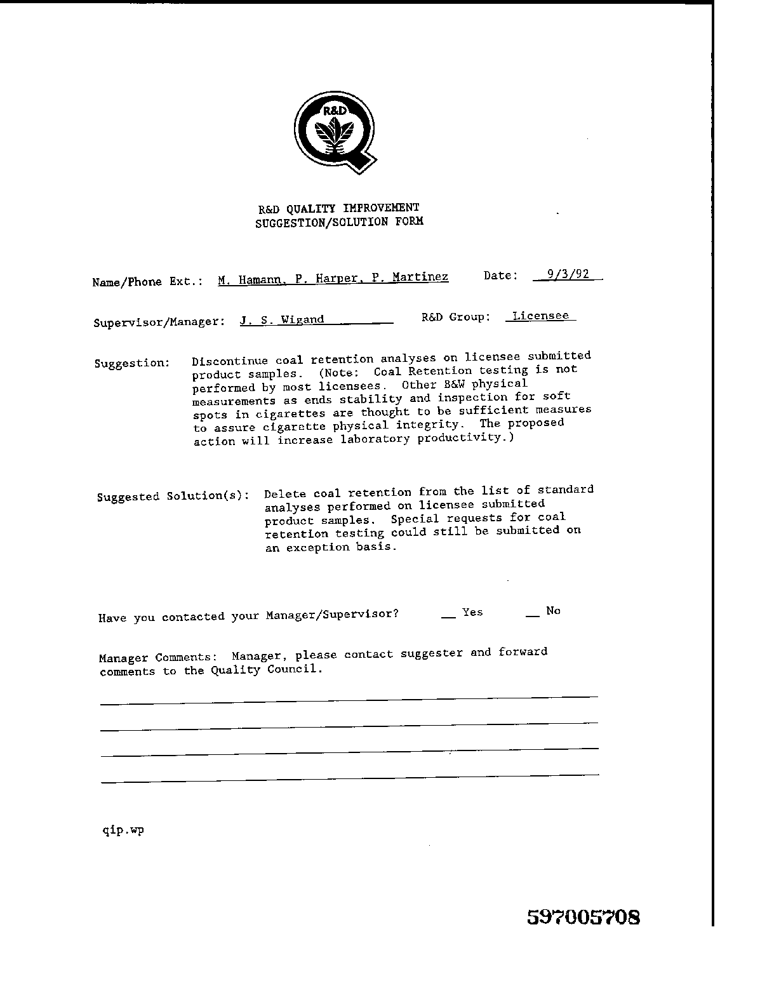

In [4]:
image

# Pipeline for **DOCVQA**

In [5]:
from transformers import pipeline

nlp = pipeline(
    "document-question-answering",
    model="impira/layoutlm-invoices",
    framework = "pt",
    # device=0  # use this for GPU
)
# model="naver-clova-ix/donut-base-finetuned-docvqa"
# model="impira/layoutlm-document-qa"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Some weights of the model checkpoint at impira/layoutlm-invoices were not used when initializing LayoutLMForQuestionAnswering: ['token_classifier_head.bias', 'token_classifier_head.weight']
- This IS expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Create batches of words and bboxes.

In [6]:
words_bbox = []
for word, bbox in zip(words,boxes):
    words_bbox.append([word,bbox])

In [ ]:
words_bbox

In [8]:
predication = nlp(
    image,
    "What is the advised solution?",
    word_boxes = words_bbox
)

In [9]:
predication

{'score': 0.01965704746544361,
 'answer': 'Discontinue coal retention analyses on licensee submitted product samples',
 'start': 36,
 'end': 44}

# Without Using the pipeline

In [12]:
from transformers import AutoProcessor, LayoutLMForQuestionAnswering, AutoTokenizer

import torch

tokenizer = AutoTokenizer.from_pretrained("impira/layoutlm-invoices", add_prefix_space=True)
model = LayoutLMForQuestionAnswering.from_pretrained("impira/layoutlm-invoices")

question =  "What is the advised solution?"

encoding = tokenizer(
    question.split(), words, is_split_into_words=True, return_token_type_ids=True, return_tensors="pt"
)
bbox = []
for i, s, w in zip(encoding.input_ids[0], encoding.sequence_ids(0), encoding.word_ids(0)):
    if s == 1:
        bbox.append(boxes[w])
    elif i == tokenizer.sep_token_id:
        bbox.append([1000] * 4)
    else:
        bbox.append([0] * 4)
encoding["bbox"] = torch.tensor([bbox])

word_ids = encoding.word_ids(0)
outputs = model(**encoding)
loss = outputs.loss
start_scores = outputs.start_logits
end_scores = outputs.end_logits
start, end = word_ids[start_scores.argmax(-1)], word_ids[end_scores.argmax(-1)]
print("-----------------------------------")
print(" ".join(words[start : end + 1]))

Some weights of the model checkpoint at impira/layoutlm-invoices were not used when initializing LayoutLMForQuestionAnswering: ['token_classifier_head.bias', 'token_classifier_head.weight']
- This IS expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-----------------------------------
Delete coal retention from the list of standard analyses performed on licensee submitted product samples.
